### Lab 3: Expectation Maximization and Variational Autoencoder

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two or three people.
* The deadline is Friday, 01.06.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.
$\newcommand{\bx}{\mathbf{x}} \newcommand{\bpi}{\mathbf{\pi}} \newcommand{\bmu}{\mathbf{\mu}} \newcommand{\bX}{\mathbf{X}} \newcommand{\bZ}{\mathbf{Z}} \newcommand{\bz}{\mathbf{z}}$

Authors:
Gabriele Bani, 11640758
Andrii Skliar, 11636785

### Installing PyTorch

In this lab we will use PyTorch. PyTorch is an open source deep learning framework primarily developed by Facebook's artificial-intelligence research group. In order to install PyTorch in your conda environment go to https://pytorch.org and select your operating system, conda, Python 3.6, no cuda. Copy the text from the "Run this command:" box. Now open a terminal and activate your 'ml2labs' conda environment. Paste the text and run. After the installation is done you should restart Jupyter.

### MNIST data

In this Lab we will use several methods for unsupervised learning on the MNIST dataset of written digits. The dataset contains digital images of handwritten numbers $0$ through $9$. Each image has 28x28 pixels that each take 256 values in a range from white ($= 0$) to  black ($=1$). The labels belonging to the images are also included. 
Fortunately, PyTorch comes with a MNIST data loader. The first time you run the box below it will download the MNIST data set. That can take a couple of minutes.
The main data types in PyTorch are tensors. For Part 1, we will convert those tensors to numpy arrays. In Part 2, we will use the torch module to directly work with PyTorch tensors.

In [51]:
%pylab inline
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()
# For EM we will use flattened data
train_data = train_data.reshape(train_data.shape[0], -1)


Populating the interactive namespace from numpy and matplotlib


/home/hiryugan/anaconda3/envs/ml2labs/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figure', 'norm', 'pi', 'sample', 'gamma', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 1: Expectation Maximization
We will use the Expectation Maximization (EM) algorithm for the recognition of handwritten digits in the MNIST dataset. The images are modelled as a Bernoulli mixture model (see Bishop $\S9.3.3$):
$$
p(\bx|\bmu, \bpi) = \sum_{k=1}^K  \pi_k \prod_{i=1}^D \mu_{ki}^{x_i}(1-\mu_{ki})^{(1-x_i)}
$$
where $x_i$ is the value of pixel $i$ in an image, $\mu_{ki}$ represents the probability that pixel $i$ in class $k$ is black, and $\{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients of classes in the data. We want to use this data set to classify new images of handwritten numbers.

### 1.1 Binary data (5 points)
As we like to apply our Bernoulli mixture model, write a function `binarize` to convert the (flattened) MNIST data to binary images, where each pixel $x_i \in \{0,1\}$, by thresholding at an appropriate level.

In [52]:
def binarize(X):
    return np.around(train_data/255)

In [53]:
# Test test test!
bin_train_data = binarize(train_data)
assert bin_train_data.dtype == np.float
assert bin_train_data.shape == train_data.shape


Sample a few images of digits $2$, $3$ and $4$; and show both the original and the binarized image together with their label.

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [55]:
def sample_digits_indices(start, stop, num_samples):
    sampled_indices = np.array([]).astype(int)
    
    sampled_sizes = []
    for i in range(start, stop+1):
        indices = np.where(train_labels == i)[0]
        if num_samples is not None:
            indices = np.random.choice(indices, num_samples)
        sampled_sizes.append(len(indices))
        sampled_indices = np.hstack((sampled_indices, indices))
        
    return sampled_indices, sampled_sizes

In [56]:
def sample_digits(sampled_indices, binary = False):
    samples = train_data[sampled_indices]
    sampled_labels = train_labels[sampled_indices]
    
    if binary:
        bin_samples = bin_train_data[sampled_indices]
        return sampled_labels, samples, bin_samples
    else:
        return sampled_labels, samples

In [57]:
def sample_data(start, stop, num_samples, binary):
    range_digits = stop - start + 1
    
    sampled_indices, sampled_sizes = sample_digits_indices(start, stop, num_samples)
    if binary:
        sampled_labels, samples, bin_samples = sample_digits(sampled_indices, binary)
        return sampled_labels, samples, bin_samples, sampled_sizes
    else:
        sampled_labels, samples = sample_digits(sampled_indices, binary)
        return sampled_labels, samples, sampled_sizes

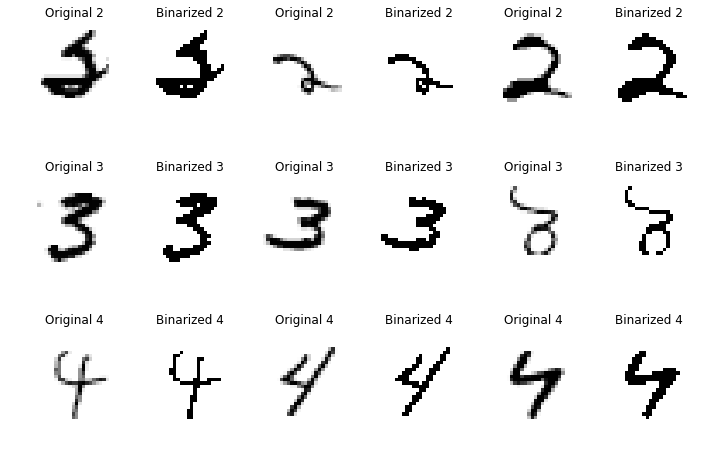

In [58]:
num_samples = 3
start_digit = 2
stop_digit = 4
range_digits = stop_digit - start_digit + 1

sampled_labels, samples, bin_samples, _ =  sample_data(start_digit, stop_digit, 
                                                    num_samples, binary = True)

sampled_labels = sampled_labels.reshape(range_digits, num_samples)
samples = samples.reshape(range_digits, num_samples, 28, 28)
bin_samples = bin_samples.reshape(range_digits, num_samples, 28, 28)

fig, axes = plt.subplots(range_digits, num_samples * 2)

for i in range(range_digits):
    for j in range(num_samples):
        k = 2*j
        
        axes[i, k].axis('off')
        axes[i, k + 1].axis('off')
        
        axes[i, k].imshow(samples[i, j], cmap='Greys')
        axes[i, k + 1].imshow(bin_samples[i, j], cmap='Greys')
        
        axes[i, k].set_title(f'Original {sampled_labels[i, j]}')
        axes[i, k+1].set_title(f'Binarized {sampled_labels[i, j]}')

### 1.2 Implementation (40 points)
You are going to write a function ```EM(X, K, max_iter)``` that implements the EM algorithm on the Bernoulli mixture model. 

The only parameters the function has are:
* ```X``` :: (NxD) array of input training images
* ```K``` :: size of the latent space
* ```max_iter``` :: maximum number of iterations, i.e. one E-step and one M-step

You are free to specify your return statement.

Make sure you use a sensible way of terminating the iteration process early to prevent unnecessarily running through all epochs. Vectorize computations using ```numpy``` as  much as possible.

You should implement the `E_step(X, mu, pi)` and `M_step(X, gamma)` separately in the functions defined below. These you can then use in your function `EM(X, K, max_iter)`.

In [59]:
def E_step(X, mu, pi):
    
    # expand dimensions for vectorizing (N x D -> N x 1 x D)
    X_expanded = np.expand_dims(X, axis=1)

    # calculate unnormalized responsibilities
    gamma_unnorm = pi * np.prod((mu ** X_expanded) * ((1 - mu) ** (1 - X_expanded)),
                                     axis = 2)
    
    # these lines are for avoiding underflow errors of the product
    # uncomment when having such errors
#     bern = (mu ** X_expanded) * ((1 - mu) ** (1 - X_expanded))
#     gamma_unnorm = pi * (np.exp(np.sum(np.log(bern), axis = 2)))    

    # calculate normalization constant
    norm_constant = np.sum(gamma_unnorm, axis = 1)

    # expand normalization constant dimensions for vectorizing (N -> N x 1)
    norm_expanded = np.expand_dims(norm_constant, axis = 1)

    # normalize responsibilities
    gamma = np.divide(gamma_unnorm, norm_expanded, where = norm_expanded!=0)

    return gamma

In [60]:
# Let's test on 5 datapoints
n_test = 5
X_test = bin_train_data[:n_test]
D_test, K_test = X_test.shape[1], 10

np.random.seed(2018)
mu_test = np.random.uniform(low=.25, high=.75, size=(K_test,D_test))
pi_test = np.ones(K_test) / K_test

gamma_test = E_step(X_test, mu_test, pi_test)
assert gamma_test.shape == (n_test, K_test)


In [61]:
def M_step(X, gamma):
    # sum over n
    N_k = gamma.sum(axis = 0)

    # calculate pi as N_k/N
    pi = N_k / np.sum(N_k)
    
    # expand dimensions and repeat for vectorizing (N x D -> N x K x D)
    # where c is the second dimension of vector gamma (N in Bishop's notation)
    X_expanded = np.repeat(np.expand_dims(X, axis=1), gamma.shape[1], axis=1)
    
    # expand dimensions for vectorizing (N x K -> N x K x 1)
    gamma_expanded = np.expand_dims(gamma, axis=2)

    # calculate unnormalized values for mu
    # results in K x D dimensional vector
    mu_unnorm = np.sum(X_expanded * gamma_expanded, axis = 0)

    # expand dimensions for vectorizing (K -> K x 1)
    N_k_expanded = np.expand_dims(N_k, axis=1)

    # normalize mu
    mu = mu_unnorm / N_k_expanded
    
    return mu, pi

In [62]:
# Oh, let's test again
mu_test, pi_test = M_step(X_test, gamma_test)

assert mu_test.shape == (K_test,D_test)
assert pi_test.shape == (K_test, )


In [63]:
def plot_MNIST_latent_representation(mu, iter = None):
    K = mu.shape[0]
    mu = mu.reshape(mu.shape[0], 28, 28)
        
    fig, axes = plt.subplots(1, K)
    
    for i in range(K):
        if iter is not None:
            axes[i].set_title(f'After iteration {iter}')
        axes[i].axis('off')
        axes[i].imshow(mu[i], cmap='Greys')

In [64]:
def EM(X, K, max_iter, eps = 1e-5, mu=None, pi=None, plot=False):
    N, D = X.shape[0], X.shape[1]
    
    if mu is None:
        mu = np.random.uniform(low=.25, high=.75, size=(K, D))
    
    if pi is None:
        pi = np.ones(K) / K
        
    gamma_prev = np.zeros((N, K))
    for i in range(max_iter):
        if plot and not (i % 5):
            plot_MNIST_latent_representation(mu, i)
        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma)
        
        delta = np.linalg.norm(gamma - gamma_prev) / gamma.shape[0]
        print(f'Epoch {i}/{max_iter}: delta of gamma - {delta}, tolerance - {eps}')
        if delta < eps:
            break
        gamma_prev = gamma

    return mu, pi, gamma

### 1.3 Three digits experiment (10 points)
In analogue with Bishop $\S9.3.3$, sample a training set consisting of only __binary__ images of written digits $2$, $3$, and $4$. Run your EM algorithm and show the reconstructed digits.

Epoch 0/500: delta of gamma - 0.0070490424913507155, tolerance - 1e-05
Epoch 1/500: delta of gamma - 0.0051387241732246845, tolerance - 1e-05
Epoch 2/500: delta of gamma - 0.004088840820088166, tolerance - 1e-05
Epoch 3/500: delta of gamma - 0.003436397103838344, tolerance - 1e-05
Epoch 4/500: delta of gamma - 0.002408677835739104, tolerance - 1e-05
Epoch 5/500: delta of gamma - 0.001363267126487797, tolerance - 1e-05
Epoch 6/500: delta of gamma - 0.0006892379917515429, tolerance - 1e-05
Epoch 7/500: delta of gamma - 0.0002604341881501465, tolerance - 1e-05
Epoch 8/500: delta of gamma - 9.748415266967077e-05, tolerance - 1e-05
Epoch 9/500: delta of gamma - 4.015764175495793e-05, tolerance - 1e-05
Epoch 10/500: delta of gamma - 9.746428292658852e-05, tolerance - 1e-05
Epoch 11/500: delta of gamma - 6.556884193446168e-05, tolerance - 1e-05
Epoch 12/500: delta of gamma - 7.856660129090118e-05, tolerance - 1e-05
Epoch 13/500: delta of gamma - 8.237123611978988e-06, tolerance - 1e-05
Mixing

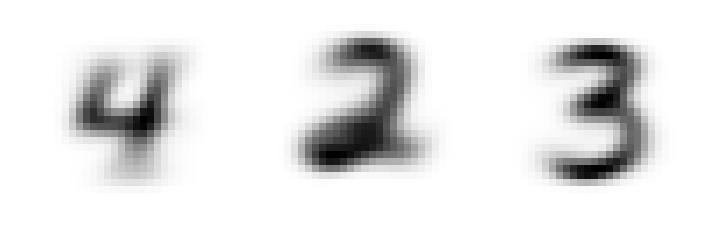

In [65]:
# None corresponds to getting all samples of specified digits
num_samples = None

start_digit = 2
stop_digit = 4
range_digits = stop_digit - start_digit + 1

max_iter = 500
latent_size = range_digits

_, _, bin_samples, _ =  sample_data(start_digit, stop_digit, num_samples, binary = True)
mu, pi, gamma = EM(bin_samples, latent_size, max_iter = max_iter, plot = False)
print(f'Mixing coefficients: {pi}')
print('Final result:')
plot_MNIST_latent_representation(mu)

Can you identify which element in the latent space corresponds to which digit? What are the identified mixing coefficients for digits $2$, $3$ and $4$, and how do these compare to the true ones?

Yes, it is easy to see from this latent space visualizations above that the first digit is a 4, the second a 2 and the thrid a 3. The calculated mixing coefficients are 0.34751217 0.31859832 0.33388951. If we assume that the data contain every digit in equal number, then the true mixing coefficients would be all 1/3, which is true in our case, since we sample data in equal number for every digit. So, the difference between the true mixing coefficients and the calculated ones is relatively small with our implementation.

### 1.4 Experiments (20 points)
Perform the follow-up experiments listed below using your implementation of the EM algorithm. For each of these, describe/comment on the obtained results and give an explanation. You may still use your dataset with only digits 2, 3 and 4 as otherwise computations can take very long.

#### 1.4.1 Size of the latent space (5 points)
Run EM with $K$ larger or smaller than the true number of classes. Describe your results.

Epoch 0/500: delta of gamma - 0.007144744590750588, tolerance - 1e-05
Epoch 1/500: delta of gamma - 0.004779654926787, tolerance - 1e-05
Epoch 2/500: delta of gamma - 0.0024882583181318084, tolerance - 1e-05
Epoch 3/500: delta of gamma - 0.0022324971529000498, tolerance - 1e-05
Epoch 4/500: delta of gamma - 0.0022835379677800917, tolerance - 1e-05
Epoch 5/500: delta of gamma - 0.002151058735035688, tolerance - 1e-05
Epoch 6/500: delta of gamma - 0.0018296689358845918, tolerance - 1e-05
Epoch 7/500: delta of gamma - 0.001386186344403166, tolerance - 1e-05
Epoch 8/500: delta of gamma - 0.0009759272094159891, tolerance - 1e-05
Epoch 9/500: delta of gamma - 0.0006955222436021928, tolerance - 1e-05
Epoch 10/500: delta of gamma - 0.0005707264176081586, tolerance - 1e-05
Epoch 11/500: delta of gamma - 0.0005288460145955689, tolerance - 1e-05
Epoch 12/500: delta of gamma - 0.0004988628924039905, tolerance - 1e-05
Epoch 13/500: delta of gamma - 0.0004766444775863425, tolerance - 1e-05
Epoch 14/

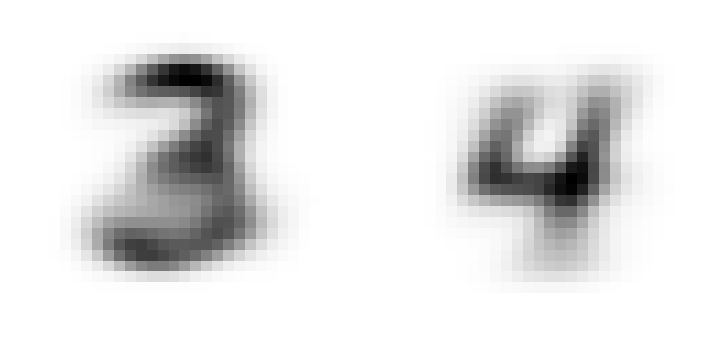

In [16]:
num_samples = None
max_iter = 500

latent_size = 2

_, _, bin_samples, _ =  sample_data(start_digit, stop_digit, num_samples, binary = True)
mu, _, _ = EM(bin_samples, latent_size, max_iter = max_iter, plot = False)
plot_MNIST_latent_representation(mu)

Epoch 0/500: delta of gamma - 0.006754877053127517, tolerance - 1e-05
Epoch 1/500: delta of gamma - 0.00757841750983632, tolerance - 1e-05
Epoch 2/500: delta of gamma - 0.003947350775148579, tolerance - 1e-05
Epoch 3/500: delta of gamma - 0.0028395653533175485, tolerance - 1e-05
Epoch 4/500: delta of gamma - 0.002429701579530734, tolerance - 1e-05
Epoch 5/500: delta of gamma - 0.002250506459919134, tolerance - 1e-05
Epoch 6/500: delta of gamma - 0.0020988478345393977, tolerance - 1e-05
Epoch 7/500: delta of gamma - 0.002045659636048078, tolerance - 1e-05
Epoch 8/500: delta of gamma - 0.001885141505463226, tolerance - 1e-05
Epoch 9/500: delta of gamma - 0.0015578157663286248, tolerance - 1e-05
Epoch 10/500: delta of gamma - 0.0012147851862863743, tolerance - 1e-05
Epoch 11/500: delta of gamma - 0.0009137315623055044, tolerance - 1e-05
Epoch 12/500: delta of gamma - 0.0007342119528952707, tolerance - 1e-05
Epoch 13/500: delta of gamma - 0.000613314523037607, tolerance - 1e-05
Epoch 14/50

Epoch 114/500: delta of gamma - 1.4448205055839004e-05, tolerance - 1e-05
Epoch 115/500: delta of gamma - 1.2736654447977601e-05, tolerance - 1e-05
Epoch 116/500: delta of gamma - 1.113823432779032e-05, tolerance - 1e-05
Epoch 117/500: delta of gamma - 9.72047096532438e-06, tolerance - 1e-05


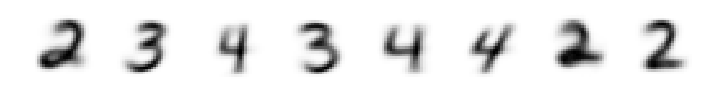

In [17]:
num_samples = None
max_iter = 500

latent_size = 8

_, _, bin_samples, _ =  sample_data(start_digit, stop_digit, num_samples, binary = True)
mu, _, _= EM(bin_samples, latent_size, max_iter = max_iter, plot = False)
plot_MNIST_latent_representation(mu)

When K is less than the number of labels, we can see that we get hidden spaces that correspond to more than one digit. In particular, the first visualization looks like a mix of digits 3 and 2 while the second one looks like a four. In general, the representation of a missing digit can infuence more than one single hidden vector.

When K is greater than the number of classes, we obtain mutiple hidden representations for the same digit. However, those capture different characteristics among the same labels. For example they can represent different styles of writing, as we can see from the figure. We have in fact different types of four, which include one with wider white space in the top, one with smaller one, and one that is inclinated to the right. Also we have different types of 2s, such as with or without an overlap of the line in the lower part of the image. In general, we could also find mixed representations of digits.

#### 1.4.2 Identify misclassifications (10 points)
How can you use the data labels to assign a label to each of the clusters/latent variables? Use this to identify images that are 'misclassified' and try to understand why they are. Report your findings.

In [18]:
from collections import Counter

def find_inferred_labels(gamma):
    mapping = {}
    
    inferred_labels = np.argmax(gamma, axis=1)
    matches_counter = Counter(zip(inferred_labels, labels)).most_common()

    for k, v in matches_counter: 
        inferred_label, true_label = k
        if inferred_label not in mapping:
            mapping[inferred_label] = true_label
        if len(mapping) == gamma.shape[0]:
            break
            
    map_function = np.vectorize(lambda x: mapping[x])
    return map_function(inferred_labels)

Epoch 0/500: delta of gamma - 0.007037781547180154, tolerance - 1e-05
Epoch 1/500: delta of gamma - 0.00527394434295638, tolerance - 1e-05
Epoch 2/500: delta of gamma - 0.0035627569378913664, tolerance - 1e-05
Epoch 3/500: delta of gamma - 0.0034087886552452242, tolerance - 1e-05
Epoch 4/500: delta of gamma - 0.002715058694992901, tolerance - 1e-05
Epoch 5/500: delta of gamma - 0.0017693330150239555, tolerance - 1e-05
Epoch 6/500: delta of gamma - 0.0011088506613732138, tolerance - 1e-05
Epoch 7/500: delta of gamma - 0.0007161957319071086, tolerance - 1e-05
Epoch 8/500: delta of gamma - 0.000519849438466495, tolerance - 1e-05
Epoch 9/500: delta of gamma - 0.0003668157248927767, tolerance - 1e-05
Epoch 10/500: delta of gamma - 0.00021119349029406873, tolerance - 1e-05
Epoch 11/500: delta of gamma - 0.00019034440776355337, tolerance - 1e-05
Epoch 12/500: delta of gamma - 0.0001814466133019971, tolerance - 1e-05
Epoch 13/500: delta of gamma - 0.00010550073981531767, tolerance - 1e-05
Epoc

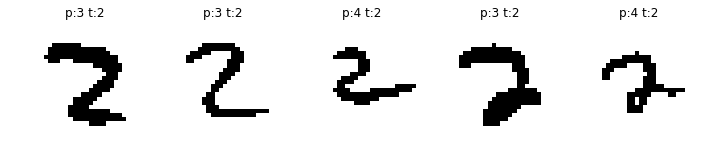

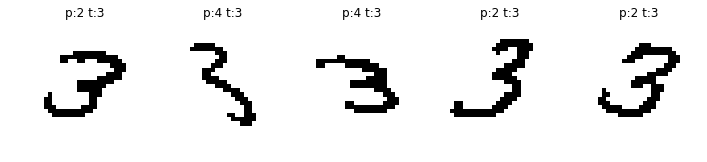

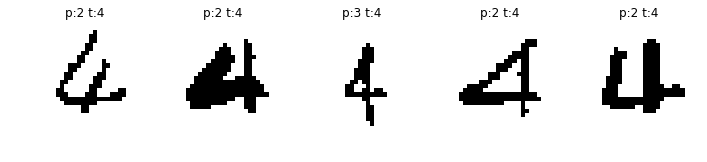

In [19]:
num_samples = None
max_iter = 500

latent_size = 3

labels, _, bin_samples, sampled_sizes =  sample_data(start_digit, stop_digit, num_samples, binary = True)
_, _, gamma = EM(bin_samples, latent_size, max_iter = max_iter, plot = False)
inferred_labels = find_inferred_labels(gamma)

for i in range(start_digit, stop_digit + 1):
    starting_index = np.sum(sampled_sizes[:i - start_digit]).astype(int)
    sample_size = sampled_sizes[i - start_digit]
    labels_per_class = inferred_labels[starting_index : starting_index + sample_size]
    true_labels = labels[starting_index : starting_index + sample_size]
    sample_per_class = bin_samples[starting_index : starting_index + sample_size]
    
    idxs = np.where(labels_per_class - true_labels != 0)[0]
    print(f'Missclassification rate for class {i}: {idxs.shape[0]/sample_size}')
    
    K = 5
    fig, axes = plt.subplots(1, K)
    
    for j, idx in enumerate(idxs[:5]):
        sample = sample_per_class[idx]
        sample = sample.reshape(28, 28)
        
        axes[j].axis('off')
        axes[j].imshow(sample, cmap='Greys')
        axes[j].set_title(f'p:{labels_per_class[idx]} t:{true_labels[idx]}')

To get predicted label of all datapoints we first find $$label_n = argmax_k (\boldsymbol{\gamma_n}) \forall x_n$$
We assume, that this value corresponds to some label from original data. However, because predicted labels can be in any position, we add +1 for each correspondence between specific position in $\boldsymbol{\gamma_n}$ and label in original data. We use this for further mapping between predicted label and original label.. 

Imagine, we get following results: 
- original labels are $\{ 3, 2, 3, 3, 4, 2, 2, 4, 4 \}$
- predicted labels are $\{ 0, 1, 0, 0, 1, 1, 0, 2, 2 \}$.

This gives us following correspondences (note that number after ":" stands for number of occurrences): $\{ (0, 3):3 ; (0, 2): 1 ; (1, 2) : 2 ; (1, 4) : 1 ; (2, 4) : 2 \}$. We choose correspondences with highest number of occurences for the same inferred label. Thus, we will have following correspondences between position in $\boldsymbol{\gamma_n}$ and true labels: $\{(0,3); (1,2); (2,4)\}$. 

**Note**, that to account for the fact that latent space can have higher dimensionality than number of classes, we allow multiple true labels to be corresponding to the same predicted label.

Afterwards, we compare these inferred labels with true labels and find number of misclassification. We have also visualized some of the misclassification in order to diagnose potential reasons for faulty performance. As we can see it, numbers which were classified incorrectly, are often not written properly and can be easily misclassified even by humans. However, some of the misclassifications are not as bad as others so this might point to the fact that EM algorithm is not advanced enough to generalize well to all the data. This might be due to the fact that that it underfits the data, as it doesn't have enough learnable parameters to account for all the data. Also, it might be due to the fact that we are only using subsamples of data and those can have internal biases so that EM fits these biases, or that it has not seen enough examples and does not generalize well.

- - - - 

Another simpler approach is to compare the euclidean distance between the $\mu$ parameters and the elements of the dataset, and registering the class for latent space $k$ as the class which has lowest average euclidean distance to $\mu_k$ over the dataset.

- - - -
From the examples above, it seems like that 2s can get mistaken as 4s when the lower horizontal bar is around the center of the image.
Regarding the digit 3 we can see that from the examples above, they get mistaken as 2s when they are a bit rotated to the right, and as 4s when the opposite happens.

In total, 4s get mistaken much less than other digits, and most of the misclassifications are between class 2 and 3.


#### 1.4.3 Initialize with true values (5 points)
Initialize the three classes with the true values of the parameters and see what happens. Report your results.

In [20]:
def init_mu_with_true(start, stop, num_samples):
    first = True
    for i in range(start, stop+1):
        _, _, bin_samples, _ =  sample_data(i, i, num_samples, binary = True)
        if first:
            mu = np.zeros((stop - start + 1, bin_samples.shape[1]))
            first = False

        avg_values = np.mean(bin_samples, axis = 0)
        mu[i - start] = avg_values
    return mu

Epoch 0/500: delta of gamma - 0.00744747981816786, tolerance - 1e-05
Epoch 1/500: delta of gamma - 0.001131502075929914, tolerance - 1e-05
Epoch 2/500: delta of gamma - 0.0006773936819290769, tolerance - 1e-05
Epoch 3/500: delta of gamma - 0.00038465966816704885, tolerance - 1e-05
Epoch 4/500: delta of gamma - 0.00022098457428914906, tolerance - 1e-05
Epoch 5/500: delta of gamma - 0.00011794313203321668, tolerance - 1e-05
Epoch 6/500: delta of gamma - 6.419858536832716e-05, tolerance - 1e-05
Epoch 7/500: delta of gamma - 3.667927162971629e-05, tolerance - 1e-05
Epoch 8/500: delta of gamma - 1.7811709826930317e-05, tolerance - 1e-05
Epoch 9/500: delta of gamma - 9.18115014533511e-06, tolerance - 1e-05


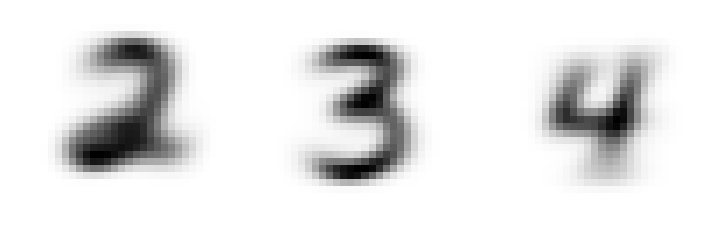

In [21]:
start_digit = 2
stop_digit = 4
range_digits = stop_digit - start_digit + 1
im_size = bin_samples.shape[1]

num_samples = None
max_iter = 500
latent_size = range_digits

mu = init_mu_with_true(start_digit, stop_digit, num_samples)
    
_, _, bin_samples, _ = sample_data(start_digit, stop_digit, num_samples, binary = True)
mu, _, _ = EM(bin_samples, latent_size, max_iter = max_iter, plot = False, mu = mu)
plot_MNIST_latent_representation(mu)

The results show the visualization of the $\mu_k$ after the EM algorithm when their values are initialized as the average digits for every class. We can see that the algorithm converges in much less number of iterations, and that the delta (average difference of elements of $\gamma_{nk}$ from the last iteration) monotonically decreases.The reason for that might be that we initialize $\mu$ with values close to a local minima in a parameter space.

## Part 2: Variational Auto-Encoder

A Variational Auto-Encoder (VAE) is a probabilistic model $p(\bx, \bz)$ over observed variables $\bx$ and latent variables and/or parameters $\bz$. Here we distinguish the decoder part, $p(\bx | \bz) p(\bz)$ and an encoder part $p(\bz | \bx)$ that are both specified with a neural network. A lower bound on the log marginal likelihood $\log p(\bx)$ can be obtained by approximately inferring the latent variables z from the observed data x using an encoder distribution $q(\bz| \bx)$ that is also specified as a neural network. This lower bound is then optimized to fit the model to the data. 

The model was introduced by Diederik Kingma (during his PhD at the UVA) and Max Welling in 2013, https://arxiv.org/abs/1312.6114. 

Since it is such an important model there are plenty of well written tutorials that should help you with the assignment. E.g: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/.

In the following, we will make heavily use of the torch module, https://pytorch.org/docs/stable/index.html. Most of the time replacing `np.` with `torch.` will do the trick, e.g. `np.sum` becomes `torch.sum` and `np.log` becomes `torch.log`. In addition, we will use `torch.FloatTensor()` as an equivalent to `np.array()`. In order to train our VAE efficiently we will make use of batching. The number of data points in a batch will become the first dimension of our data tensor, e.g. A batch of 128 MNIST images has the dimensions [128, 1, 28, 28]. To check check the dimensions of a tensor you can call `.size()`.

### 2.1 Loss function
The objective function (variational lower bound), that we will use to train the VAE, consists of two terms: a log Bernoulli loss (reconstruction loss) and a Kullback–Leibler divergence. We implement the two terms separately and combine them in the end.
As seen in Part 1: Expectation Maximization, we can use a multivariate Bernoulli distribution to model the likelihood $p(\bx | \bz)$ of black and white images. Formally, the variational lower bound is maximized but in PyTorch we are always minimizing therefore we need to calculate the negative log Bernoulli loss and Kullback–Leibler divergence.

### 2.1.1 Negative Log Bernoulli loss (5 points)
The negative log Bernoulli loss is defined as,

\begin{align}
loss = - (\sum_i^D \bx_i \log \hat{\bx_i} + (1 − \bx_i) \log(1 − \hat{\bx_i})).
\end{align}

Write a function `log_bernoulli_loss` that takes a D dimensional vector `x`, its reconstruction `x_hat` and returns the negative log Bernoulli loss. Make sure that your function works for batches of arbitrary size.

In [22]:
def log_bernoulli_loss(x_hat, x):
    loss = -torch.sum(x * torch.log(x_hat) + (1 - x) * torch.log(1 - x_hat))
    return loss


In [23]:
### Test test test
x_test = torch.FloatTensor([[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.9, 0.9, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33, 0.44], [0.55, 0.66, 0.77, 0.88], [0.99, 0.99, 0.99, 0.99]])

assert log_bernoulli_loss(x_hat_test, x_test) > 0.0
assert log_bernoulli_loss(x_hat_test, x_test) < 10.0


### 2.1.2 Negative Kullback–Leibler divergence (10 Points)
The variational lower bound (the objective to be maximized) contains a KL term $D_{KL}(q(\bz)||p(\bz))$ that can often be calculated analytically. In the VAE we assume $q = N(\bz, \mu, \sigma^2I)$ and $p = N(\bz, 0, I)$. Solve analytically!


We can express the KL divergence as
\begin{align*}
	KL(q || p) &= - \int q(\mathbf{z}) \ln \big( \frac{p(\mathbf{z})}{q(\mathbf{z})} \big) d\mathbf{z} = -\int q(\mathbf{z}) \big( \ln p(\mathbf{z}) - q(\mathbf{z}) \big) d\mathbf{z} \\
	&= -\int q(\mathbf{z}) \ln p(\mathbf{z}) d\mathbf{z} - \big[ - \int q(\mathbf{z}) \ln q(\mathbf{z}) d\mathbf{z}  \big] \end{align*}

so that we can divide the problem in two similar integrals. This kind of integral with normals as functions $p$ and $q$ is known.
As derived in homework 2, if $p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{m}, \mathbf{L})$ and $q=\mathcal{N}(\mathbf{z} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$, then
\begin{align*}
	-\int q(\mathbf{z}) \ln p(\mathbf{z}) d\mathbf{z} = \frac{D}{2} \ln 2 \pi +\frac{1}{2} \ln |\mathbf{L}| +\frac{1}{2} Tr(\mathbf{L}^{-1} \boldsymbol{\Sigma})  +\frac{1}{2} (\boldsymbol{\mu} - \mathbf{m})^T L^{-1} (\boldsymbol{\mu} - \mathbf{m})
\end{align*}


For the variational autoencoder case, we have then 
\begin{align*}
	-\int q(\mathbf{z}) \ln p(\mathbf{z}) d\mathbf{z}  &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \ln |\mathbf{L}| +\frac{1}{2} Tr(\mathbf{L}^{-1} \boldsymbol{\Sigma})  +\frac{1}{2} (\boldsymbol{\mu} - \mathbf{m})^T \mathbf{L}^{-1} (\boldsymbol{\mu} - \mathbf{m}) \\
	&=  \frac{D}{2} \ln 2 \pi   +\frac{1}{2} Tr( \boldsymbol{\sigma}^2 \mathbf{I})  +\frac{1}{2} \boldsymbol{\mu} ^T  \boldsymbol{\mu} = \frac{D}{2} \ln 2 \pi   +\frac{1}{2} \sum_{d=1}^{D} (\sigma_d^2  + \mu_d^2)\\
	-\int q(\mathbf{z}) \ln q(\mathbf{z}) d\mathbf{z}  &= \frac{D}{2} \ln 2 \pi +\frac{1}{2} \ln |\boldsymbol{\Sigma}| +\frac{D}{2} = \frac{D}{2} \ln 2 \pi +\frac{1}{2} \sum_{d=1}^{D} \log \sigma_d^2 +\frac{D}{2} 
\end{align*}

From those expressions, and the KL expression above, it follows that

\begin{align*}
	KL(q || p) &= - \frac{1}{2} \sum_{d=1}^{D} (1 + \log \sigma_d^2  - \sigma_d^2  - \mu_d^2)
\end{align*}

------------------------











Write a function `KL_loss` that takes two J dimensional vectors `mu` and `logvar` and returns the negative Kullback–Leibler divergence. Where `logvar` is $\log(\sigma^2)$. Make sure that your function works for batches of arbitrary size.

In [24]:
def KL_loss(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss


In [25]:
### Test test test
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert KL_loss(mu_test, logvar_test) > 0.0
assert KL_loss(mu_test, logvar_test) < 10.0


### 2.1.3 Putting the losses together (5 points)
Write a function `loss_function` that takes a D dimensional vector `x`, its reconstruction `x_hat`, two J dimensional vectors `mu` and `logvar` and returns the final loss. Make sure that your function works for batches of arbitrary size.

In [26]:
def loss_function(x_hat, x, mu, logvar):
    loss = log_bernoulli_loss(x_hat, x) + KL_loss(mu, logvar)
    return loss


In [27]:
x_test = torch.FloatTensor([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]])
x_hat_test = torch.FloatTensor([[0.11, 0.22, 0.33], [0.44, 0.55, 0.66], [0.77, 0.88, 0.99]])
mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

assert loss_function(x_hat_test, x_test, mu_test, logvar_test) > 0.0
assert loss_function(x_hat_test, x_test, mu_test, logvar_test) < 10.0


### 2.2 The model
Below you see a data structure for the VAE. The modell itself consists of two main parts the encoder (images $\bx$ to latent variables $\bz$) and the decoder (latent variables $\bz$ to images $\bx$). The encoder is using 3 fully-connected layers, whereas the decoder is using fully-connected layers. Right now the data structure is quite empty, step by step will update its functionality. For test purposes we will initialize a VAE for you. After the data structure is completed you will do the hyperparameter search.


In [28]:
from torch import nn
from torch.nn import functional as F 

class VAE(nn.Module):
    def __init__(self, fc1_dims, fc21_dims, fc22_dims, fc3_dims, fc4_dims):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(*fc1_dims)
        self.fc21 = nn.Linear(*fc21_dims)
        self.fc22 = nn.Linear(*fc22_dims)
        self.fc3 = nn.Linear(*fc3_dims)
        self.fc4 = nn.Linear(*fc4_dims)

    def encode(self, x):
        # To be implemented
        raise Exception('Method not implemented')

    def reparameterize(self, mu, logvar):
        # To be implemented
        raise Exception('Method not implemented')

    def decode(self, z):
        # To be implemented
        raise Exception('Method not implemented')

    def forward(self, x):
        # To be implemented
        raise Exception('Method not implemented')

VAE_test = VAE(fc1_dims=(784, 4), fc21_dims=(4, 2), fc22_dims=(4, 2), fc3_dims=(2, 4), fc4_dims=(4, 784))


### 2.3 Encoding (10 points)
Write a function `encode` that gets a vector `x` with 784 elements (flattened MNIST image) and returns `mu` and `logvar`. Your function should use three fully-connected layers (`self.fc1()`, `self.fc21()`, `self.fc22()`). First, you should use `self.fc1()` to embed `x`. Second, you should use `self.fc21()` and `self.fc22()` on the embedding of `x` to compute `mu` and `logvar` respectively. PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.  

In [29]:
def encode(self, x):
    h1 = F.relu(self.fc1(x))
    mu = self.fc21(h1)
    logvar = self.fc22(h1)
    return mu, logvar


In [30]:
### Test, test, test
VAE.encode = encode

x_test = torch.ones((5,784))
mu_test, logvar_test = VAE_test.encode(x_test)

assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.4 Reparameterization (10 points)
One of the major question that the VAE is answering, is 'how to take derivatives with respect to the parameters of a stochastic variable?', i.e. if we are given $\bz$ that is drawn from a distribution $q(\bz|\bx)$, and we want to take derivatives. This step is necessary to be able to use gradient-based optimization algorithms like SGD.
For some distributions, it is possible to reparameterize samples in a clever way, such that the stochasticity is independent of the parameters. We want our samples to deterministically depend on the parameters of the distribution. For example, in a normally-distributed variable with mean $\mu$ and standard deviation $\sigma$, we can sample from it like this:

\begin{align}
\bz = \mu + \sigma \odot \epsilon,
\end{align}

where $\odot$ is the element-wise multiplication and $\epsilon$ is sampled from $N(0, I)$.


Write a function `reparameterize` that takes two J dimensional vectors `mu` and `logvar`. It should return $\bz = \mu + \sigma \odot \epsilon$.


In [31]:
def reparameterize(self, mu, logvar):
    std = torch.exp(1/2 * logvar)
    eps = torch.randn_like(std)
    z = mu + std * eps 
    return z


In [32]:
### Test, test, test
VAE.reparameterize = reparameterize
VAE_test.train()

mu_test = torch.FloatTensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])
logvar_test = torch.FloatTensor([[0.01, 0.02], [0.03, 0.04], [0.05, 0.06]])

z_test = VAE_test.reparameterize(mu_test, logvar_test)

assert np.allclose(z_test.size(), [3, 2])
assert z_test[0][0] < 5.0
assert z_test[0][0] > -5.0


### 2.5 Decoding (10 points)
Write a function `decode` that gets a vector `z` with J elements and returns a vector `x_hat` with 784 elements (flattened MNIST image). Your function should use two fully-connected layers (`self.fc3()`, `self.fc4()`). PyTorch comes with a variety of activation functions, the most common calls are `F.relu()`, `F.sigmoid()`, `F.tanh()`. Make sure that your function works for batches of arbitrary size.

In [33]:
def decode(self, z):
    x_hat = F.relu(self.fc3(z))
    x_hat = F.sigmoid(self.fc4(x_hat))
    return x_hat


In [34]:
# test test test
VAE.decode = decode

z_test = torch.ones((5,2))
x_hat_test = VAE_test.decode(z_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert (x_hat_test <= 1).all()
assert (x_hat_test >= 0).all()


### 2.6 Forward pass (10)
To complete the data structure you have to define a forward pass through the VAE. A single forward pass consists of the encoding of an MNIST image $\bx$ into latent space $\bz$, the reparameterization of $\bz$ and the decoding of $\bz$ into an image $\bx$.

Write a function `forward` that gets a a vector `x` with 784 elements (flattened MNIST image) and returns a vector `x_hat` with 784 elements (flattened MNIST image), `mu` and `logvar`.

In [35]:
def forward(self, x):
    x = x.view(-1, 784)
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_hat = self.decode(z)
    return x_hat, mu, logvar


In [36]:
# test test test 
VAE.forward = forward

x_test = torch.ones((5,784))
x_hat_test, mu_test, logvar_test = VAE_test.forward(x_test)

assert np.allclose(x_hat_test.size(), [5, 784])
assert np.allclose(mu_test.size(), [5, 2])
assert np.allclose(logvar_test.size(), [5, 2])


### 2.7 Training (15)
We will now train the VAE using an optimizer called Adam, https://arxiv.org/abs/1412.6980. The code to train a model in PyTorch is given below.

In [37]:
from torch.autograd import Variable

def train(epoch, train_loader, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


Let's train. You have to choose the hyperparameters. Make sure your loss is going down in a reasonable amount of epochs (around 10).

In [38]:
# Hyperparameters
fc1_dims = (784, 400)
fc21_dims = (400, 20)
fc22_dims = (400, 20)
fc3_dims = (20, 400)
fc4_dims = (400, 784)
lr = 0.001
batch_size = 128
epochs = 10


In [39]:
# This cell contains a hidden test, please don't delete it, thx

Run the box below to train the model using the hyperparameters you entered above.

In [40]:
from torchvision import datasets, transforms
from torch import nn, optim

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)


Train Epoch: 1 [0/60000 (0%)]	Loss: 549.080933
Train Epoch: 1 [12800/60000 (21%)]	Loss: 174.812973
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.863464
Train Epoch: 1 [38400/60000 (64%)]	Loss: 140.523712
Train Epoch: 1 [51200/60000 (85%)]	Loss: 136.123383
====> Epoch: 1 Average loss: 164.1155
Train Epoch: 2 [0/60000 (0%)]	Loss: 130.457916
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.440216
Train Epoch: 2 [25600/60000 (43%)]	Loss: 121.119637
Train Epoch: 2 [38400/60000 (64%)]	Loss: 117.109848
Train Epoch: 2 [51200/60000 (85%)]	Loss: 118.635345
====> Epoch: 2 Average loss: 121.3830
Train Epoch: 3 [0/60000 (0%)]	Loss: 116.411163
Train Epoch: 3 [12800/60000 (21%)]	Loss: 107.948074
Train Epoch: 3 [25600/60000 (43%)]	Loss: 113.194458
Train Epoch: 3 [38400/60000 (64%)]	Loss: 111.878311
Train Epoch: 3 [51200/60000 (85%)]	Loss: 116.621796
====> Epoch: 3 Average loss: 114.3433
Train Epoch: 4 [0/60000 (0%)]	Loss: 112.258392
Train Epoch: 4 [12800/60000 (21%)]	Loss: 112.560303
Train Epoch: 4 [25600/

Run the box below to check if the model you trained above is able to correctly reconstruct images.

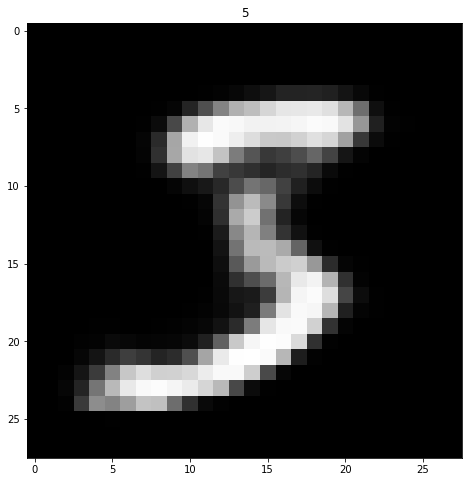

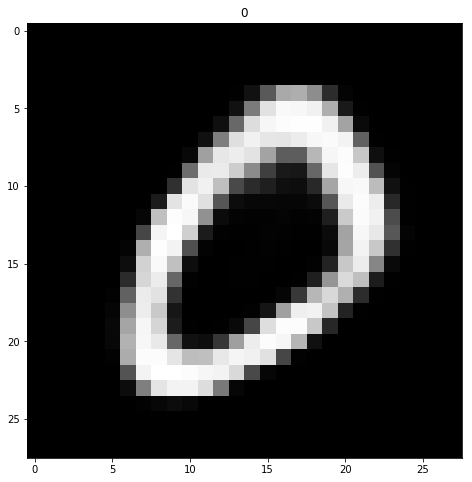

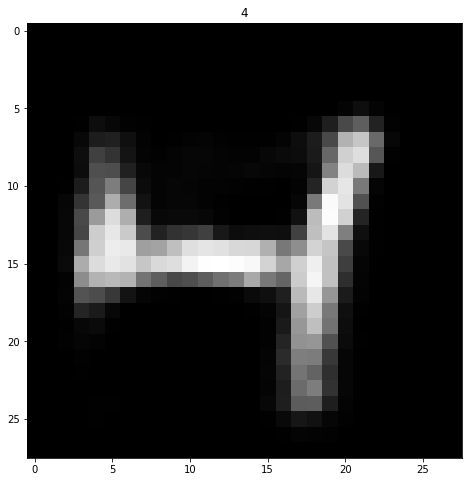

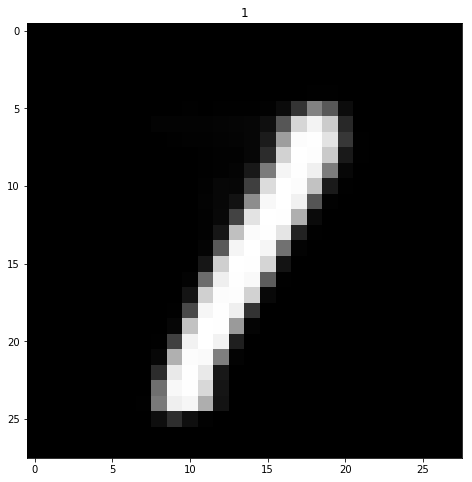

In [41]:
### Let's check if the reconstructions make sense
# Set model to test mode
VAE_MNIST.eval()
    
# Reconstructed
train_data_plot = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader_plot = torch.utils.data.DataLoader(train_data_plot,
                                           batch_size=1, shuffle=False, **{})

for batch_idx, (data, _) in enumerate(train_loader_plot):
    x_hat, mu, logvar = VAE_MNIST(data)
    plt.imshow(x_hat.view(1,28,28).squeeze().data.numpy(), cmap='gray')
    plt.title('%i' % train_data.train_labels[batch_idx])
    plt.show()
    if batch_idx == 3:
        break


### 2.8 Visualize latent space (20 points)
Now, implement the auto-encoder now with a 2-dimensional latent space, and train again over the MNIST data. Make a visualization of the learned manifold by using a linearly spaced coordinate grid as input for the latent space, as seen in  https://arxiv.org/abs/1312.6114 Figure 4.

In [42]:
fc1_dims = (784, 128)
fc21_dims = (128, 2)
fc22_dims = (128, 2)
fc3_dims = (2, 128)
fc4_dims = (128, 784)
lr = 0.001
batch_size = 128
epochs = 10

# Load data
train_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, shuffle=True, **{})

# Init model
VAE_MNIST = VAE(fc1_dims=fc1_dims, fc21_dims=fc21_dims, fc22_dims=fc22_dims, fc3_dims=fc3_dims, fc4_dims=fc4_dims)

# Init optimizer
optimizer = optim.Adam(VAE_MNIST.parameters(), lr=lr)

# Train
for epoch in range(1, epochs + 1):
    train(epoch, train_loader, VAE_MNIST, optimizer)

Train Epoch: 1 [0/60000 (0%)]	Loss: 554.592590
Train Epoch: 1 [12800/60000 (21%)]	Loss: 209.523148
Train Epoch: 1 [25600/60000 (43%)]	Loss: 191.917328
Train Epoch: 1 [38400/60000 (64%)]	Loss: 182.557785
Train Epoch: 1 [51200/60000 (85%)]	Loss: 172.512238
====> Epoch: 1 Average loss: 204.5454
Train Epoch: 2 [0/60000 (0%)]	Loss: 175.624649
Train Epoch: 2 [12800/60000 (21%)]	Loss: 175.830200
Train Epoch: 2 [25600/60000 (43%)]	Loss: 173.224213
Train Epoch: 2 [38400/60000 (64%)]	Loss: 179.612778
Train Epoch: 2 [51200/60000 (85%)]	Loss: 163.673264
====> Epoch: 2 Average loss: 174.6481
Train Epoch: 3 [0/60000 (0%)]	Loss: 173.196152
Train Epoch: 3 [12800/60000 (21%)]	Loss: 170.953735
Train Epoch: 3 [25600/60000 (43%)]	Loss: 168.407883
Train Epoch: 3 [38400/60000 (64%)]	Loss: 172.898041
Train Epoch: 3 [51200/60000 (85%)]	Loss: 162.724609
====> Epoch: 3 Average loss: 169.6187
Train Epoch: 4 [0/60000 (0%)]	Loss: 170.613419
Train Epoch: 4 [12800/60000 (21%)]	Loss: 171.693802
Train Epoch: 4 [25600/

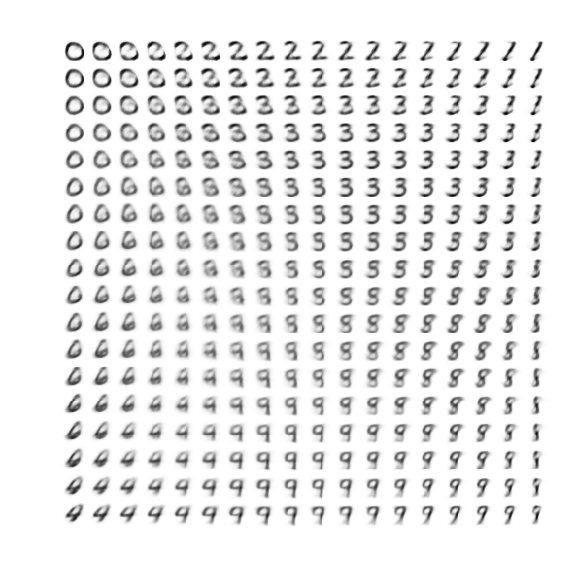

In [43]:
from scipy.stats import norm

# Display a 2D manifold of the digits
grid_size = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * grid_size, digit_size * grid_size))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0, 1, grid_size))
grid_y = norm.ppf(np.linspace(0, 1, grid_size))

# # decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = VAE_MNIST.decode(torch.FloatTensor(z_sample))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.data.numpy()

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(figure, cmap='Greys')
plt.show()  

### 2.8 Amortized inference (10 points)
What is amortized inference? Where in the code of Part 2 is it used? What is the benefit of using it?


Amortized inference refers to using past inferences as a base for future computations. In our case, we have that instead of approximating separate variables for each datapoint, we assume that latent variables can be predicted by a parametrized function of the data. This function is estimated using neural networks, so that latent variables can be obtained by passing new data points through the network.

In our code, it is used in the encoder $q_{\phi}(z | x)$, because the modeled distribution does not depend on local parameters, but is conditioned on the data and parametrized by global parameters $\phi$. This has the advantage of allowing the generation (sampling) of new datapoints starting from the latent variables.